In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install wget

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
df.shape

(962, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [ ]:
df.isna().sum()

Category    0
Resume      0
dtype: int64

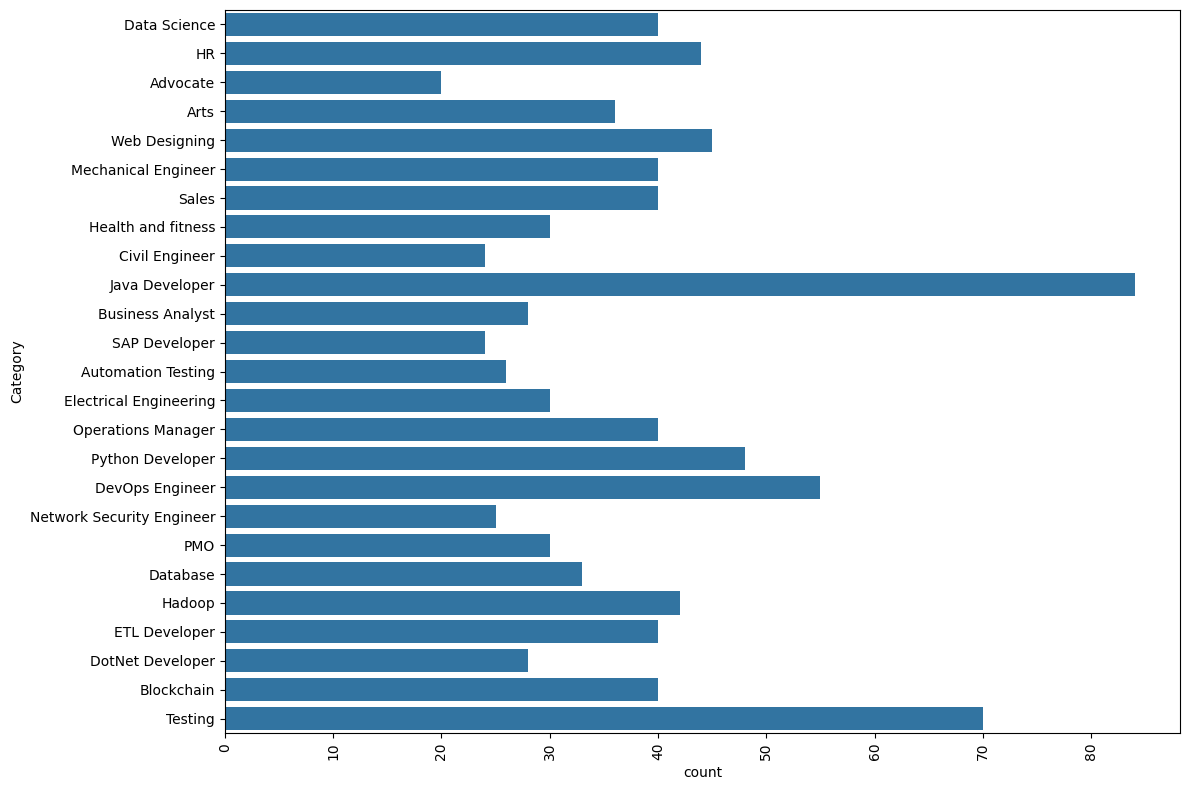

In [ ]:
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.tight_layout();

In [ ]:
print("Total number of available jobs:", df.Category.nunique())

Total number of available jobs: 25


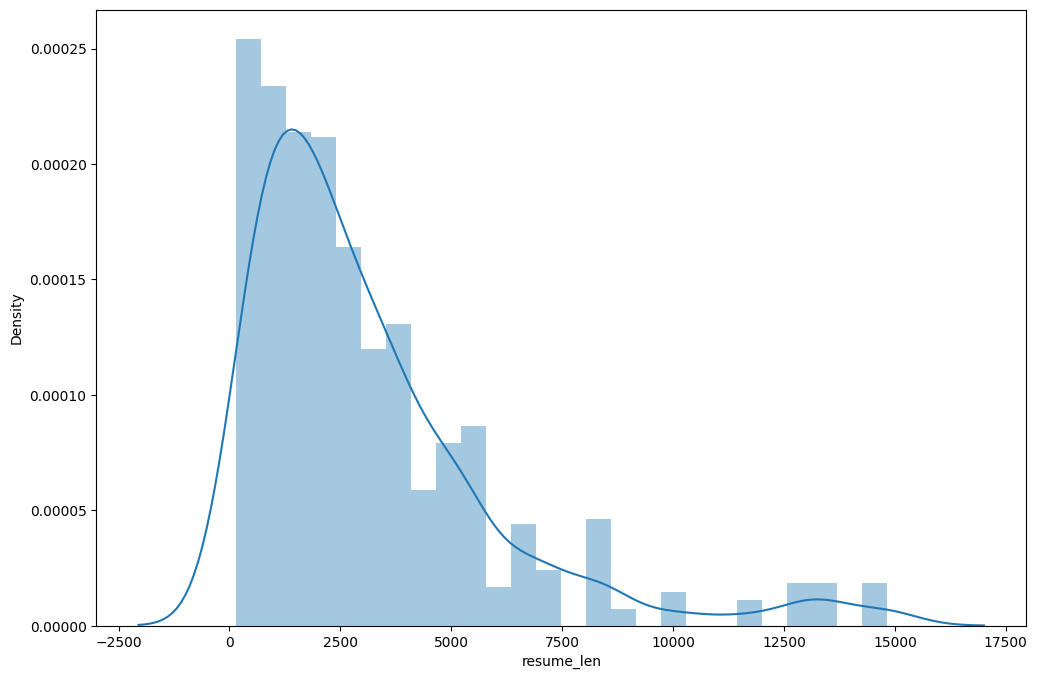

In [ ]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len);

In [ ]:
df.describe()

,resume_len
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


In [ ]:
max_resume_len = 200

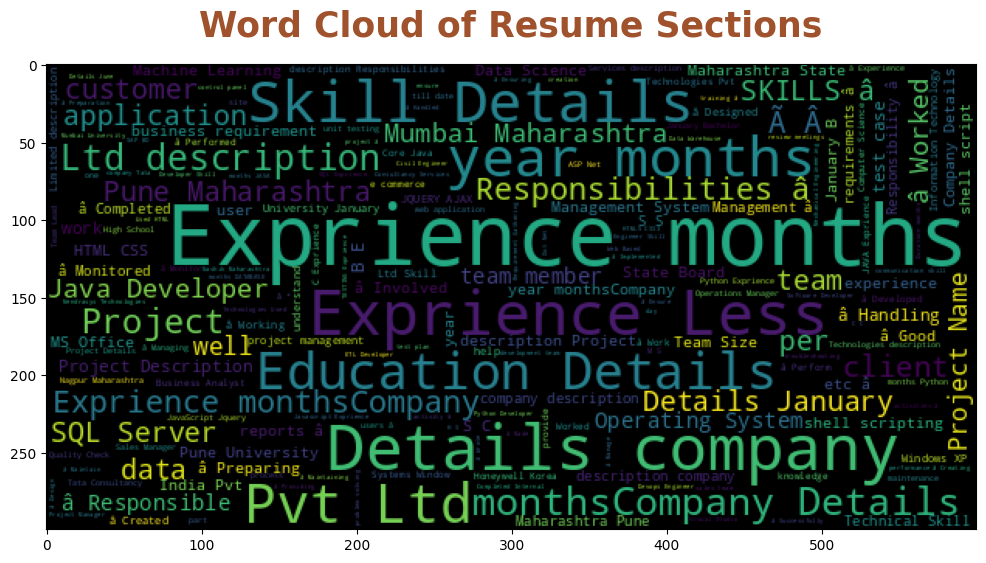

In [ ]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections',pad=20,fontsize=25,fontweight='bold',color='sienna')
plt.imshow(wc);

In [ ]:
labels_dict = {}

for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx

labels_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [ ]:
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

In [ ]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = text_preprocess(df,'Resume')
preprocessed_df.head()

,Category,Resume,resume_len
0,0,skills programming languages python pandas num...,4786
1,0,education details may may b e uitrgpv data sci...,1268
2,0,areas interest deep learning control system de...,1871
3,0,skills r python sap hana tableau sap hana sql ...,6995
4,0,education details mca ymcaust faridabad haryan...,452


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("manishiitg/distilbert-resume-parts-classify")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("manishiitg/distilbert-resume-parts-classify",from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101)

In [ ]:
X_train = tokenizer(text=train_df.Resume.tolist(),
                   add_special_tokens=True,
                   padding=True,
                   truncation=True,
                   max_length=max_resume_len,
                   return_tensors='tf',
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.Resume.tolist(),
                  add_special_tokens=True,
                  padding=True,
                  truncation=True,
                  max_length=max_resume_len,
                  return_tensors='tf',
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=1)

In [ ]:
input_ids = Input(shape=(max_resume_len,),dtype=tf.int32,name='input_ids')
attention_masks = Input(shape=(max_resume_len,),dtype=tf.int32,name='attention_mask')

In [ ]:
word_embeddings = bert_model(input_ids,attention_mask=attention_masks)[0] # 0 --> final hidden state, 1 --> pooling output

output = Flatten()(word_embeddings)
output = Dense(units=1024,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=25,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_masks],outputs=output)
model.layers

In [ ]:
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6696270   ['input_ids[0][0]',           
 e_classification_3 (TFDist  (loss=None, logits=(None,    0          'attention_mask[0][0]']      
 ilBertForSequenceClassific  12),                                                           

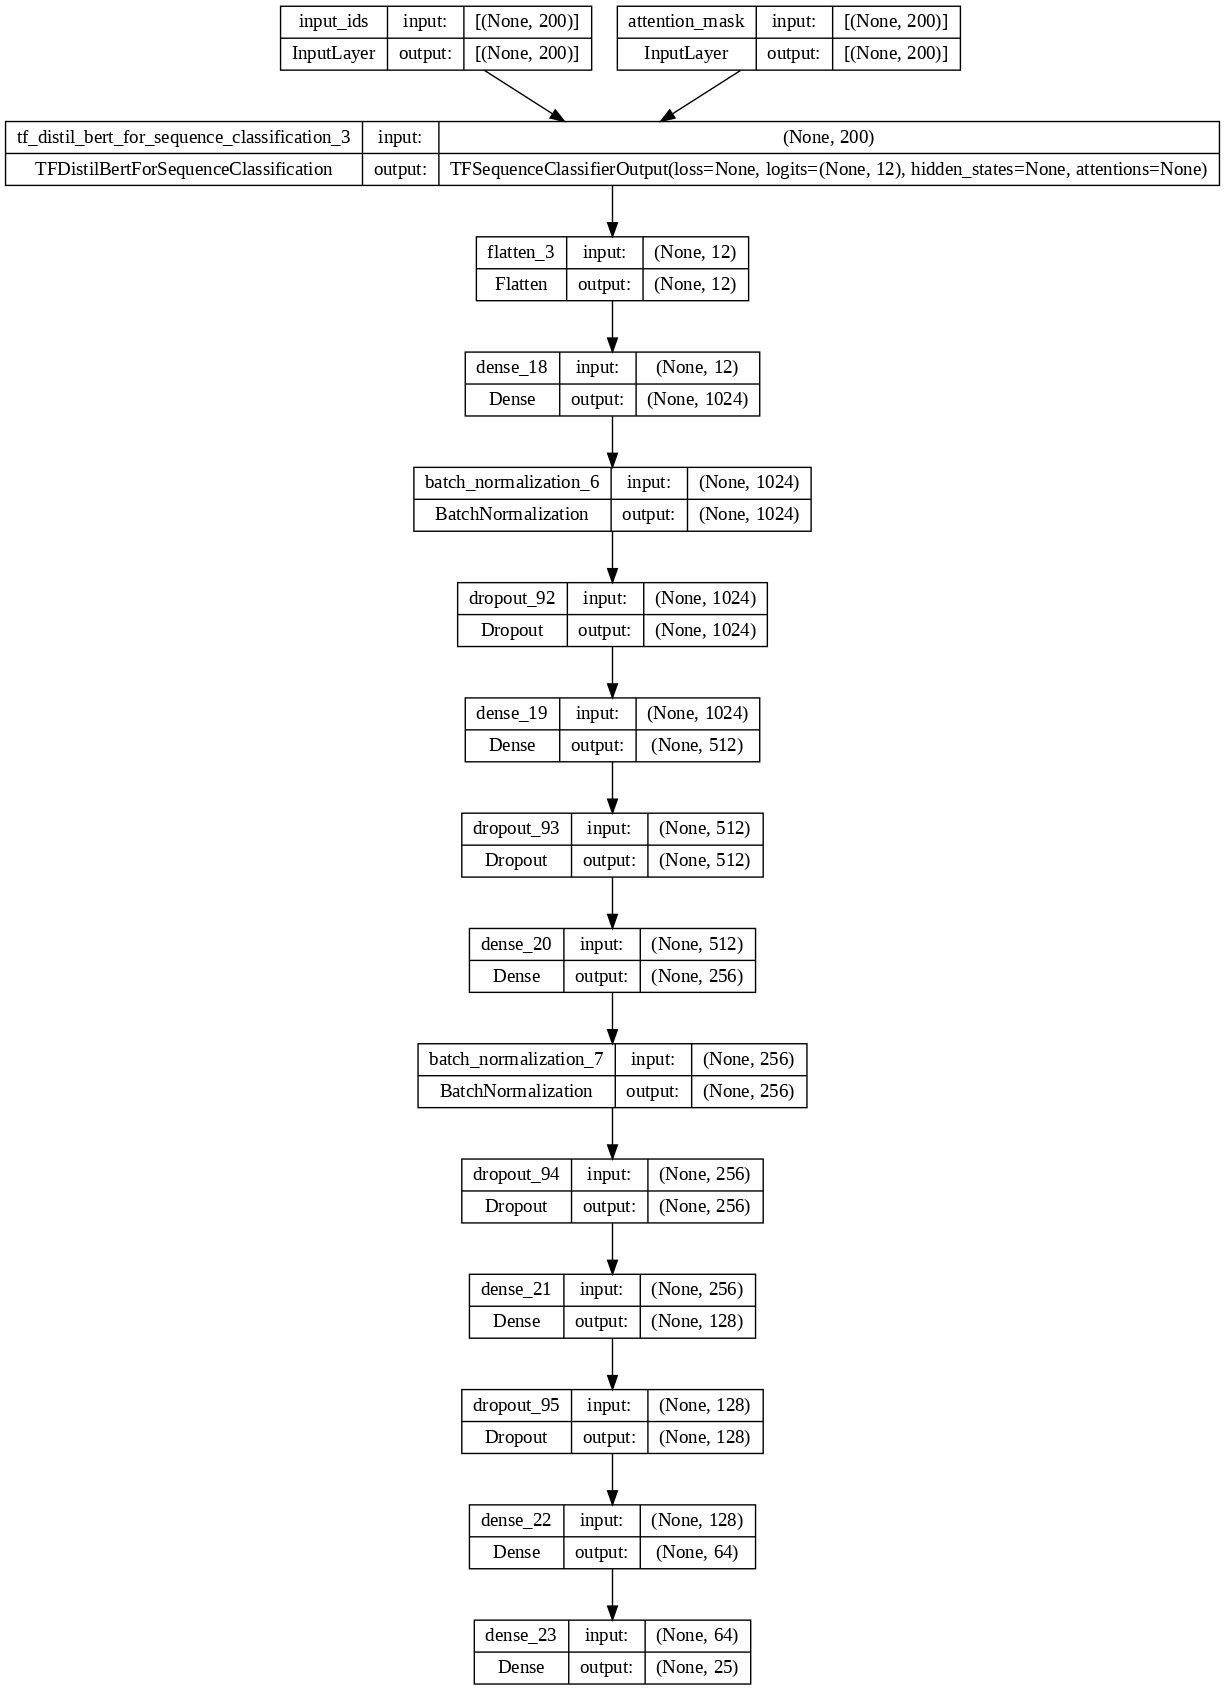

In [ ]:
plot_model(model,to_file='model.png',dpi=100,show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Use the 'amsgrad' argument instead of 'decay'
adam = Adam(learning_rate=5e-5, epsilon=2e-8, amsgrad=True, clipnorm=1.0)


In [ ]:
adam = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           amsgrad=True,
           clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=SparseCategoricalAccuracy('balanced_accuracy'))

In [ ]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=250,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint('resume_parser.h5',monitor='val_balanced_accuracy',mode='max',verbose=1,save_best_only=True)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.Category,
             epochs=500,
             batch_size=32,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.Category))

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 3.6261 - balanced_accuracy: 0.0387
Epoch 1: val_balanced_accuracy improved from -inf to 0.03460, saving model to resume_parser.h5
22/22 [==============================] - 27s 608ms/step - loss: 3.6255 - balanced_accuracy: 0.0386 - val_loss: 3.2176 - val_balanced_accuracy: 0.0346
Epoch 2/500
21/22 [===========================>..] - ETA: 0s - loss: 3.5048 - balanced_accuracy: 0.0387
Epoch 2: val_balanced_accuracy improved from 0.03460 to 0.03806, saving model to resume_parser.h5
22/22 [==============================] - 8s 371ms/step - loss: 3.5044 - balanced_accuracy: 0.0401 - val_loss: 3.2121 - val_balanced_accuracy: 0.0381
Epoch 3/500
21/22 [===========================>..] - ETA: 0s - loss: 3.3861 - balanced_accuracy: 0.0565
Epoch 3: val_balanced_accuracy improved from 0.03806 to 0.04498, saving model to resume_parser.h5
22/22 [==============================] - 8s 394ms/step - loss: 3.3858 - balanced_accuracy: 0.0565 

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
test_predictions

10/10 [==============================] - 3s 184ms/step


array([ 3, 14,  0,  0,  9, 10, 24, 21,  9, 15, 18, 13, 24, 24, 14,  7,  3,
       17, 23,  0, 13, 17,  9, 11, 14, 20,  4,  9, 17,  9, 20,  4,  4, 21,
        6, 12,  9, 23, 12, 24, 14, 24, 10,  9,  9, 18, 10, 21, 23,  3, 14,
       20, 14, 12,  1, 24,  6, 23, 16,  6, 12, 21, 14, 23, 24,  0, 16,  5,
        7, 22, 10,  0,  6,  2, 23,  3,  8,  3, 15, 18, 24, 19, 17,  3,  4,
       22, 17, 20, 14, 24,  9, 21,  0, 15,  3, 20, 20,  4, 10,  9,  9, 24,
       17, 11, 16,  1,  5,  3,  3,  9, 23, 17, 16,  0, 18, 22, 20,  4, 14,
       16, 14, 21, 17,  3,  5, 20,  1, 23,  5,  5,  8, 14,  6, 10, 15, 21,
        3,  9, 18,  0, 19, 10,  6,  5,  9,  7, 19,  5,  6,  4,  3,  4, 11,
        6,  9,  1,  5, 12, 20, 17, 13,  4, 13,  9, 16, 15,  9,  0, 24, 11,
       24, 21, 10, 18, 11, 11, 15,  5, 11, 24, 11,  4, 20, 18, 11, 24, 14,
        4,  6,  4,  0, 16, 21, 13,  4, 21,  4, 11, 14,  4,  5,  7, 17,  1,
        6,  7, 16, 23, 18, 14, 11, 23, 12, 23,  3, 21,  9, 11,  3, 20,  1,
       20, 14, 16, 20, 11